<a href="https://colab.research.google.com/github/valesierrai/Analisis-Supervisado-para-el-AD/blob/main/Parcial_2_VSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Redes Neuronales Recurrentes (RNN)

El **objetivo** de este trabajo es diseñar un modelo de red neuronal recurrente, capaz de predecir la valoración de la franquicia de McDonalds, a partir de las reseñas o comentarios de los usuarios.

La base de datos 'McDonald_s_Reviews.csv' fue sacada de Kaggle: https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews


Este ejemplo se basó de un 'Proyecto de Red Neuronal Recurrente' recuperado de LinkedIn: https://www.linkedin.com/pulse/proyecto-red-neuronal-recurrente-para-predecir-la-o-ruben-garcia/


##0. Cargamos Librerias

In [ ]:
#Instalamos Tensorflow
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords # conjunto de stopwords
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

##1. Cargamos  y Revisamos la Base de Datos

In [ ]:
dataset = pd.read_csv('/content/McDonald_s_Reviews.csv', encoding = 'latin-1')
dataset.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [ ]:
#Revisamos los datos en busca de datos faltantes
dataset.isnull().sum()

,0
reviewer_id,0
store_name,0
category,0
store_address,0
latitude,660
longitude,660
rating_count,0
review_time,0
review,0
rating,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB


In [ ]:
#Borramos los datos faltantes
dataset = dataset.dropna()

#Revisamos
dataset.isnull().sum()

,0
reviewer_id,0
store_name,0
category,0
store_address,0
latitude,0
longitude,0
rating_count,0
review_time,0
review,0
rating,0


Vamos a sacar los sentimientos de las reseñas de McDonalds. Puesto que la etiqueta del conjunto de datos, sobre el cual pretendemos construir un predictor de clasificación, corresponde a la columna "sentiment" la cual tendrá valores tanto positivos como negativos.

In [ ]:
#Definimos el algoritmo base
sia = SentimentIntensityAnalyzer()

#Definimos la función para poder extraer los sentimientos
def analisis_sentimiento(texto):
  """
  Recibe un texto
  Retorna el sentimiento del texto, negativo, positivo, neutral
  """
  sentimiento = sia.polarity_scores(texto)['compound']  # Devuelve un diccionario con los resultados
  if sentimiento >0:
    etiqueta= "positivo"
  elif sentimiento <0:
    etiqueta= "negativo"
  else:
    etiqueta= "neutral"
  return etiqueta

In [ ]:
#Creamos una columna dentro del dataset con los sentimientos correspondientes
dataset["sentimiento"]=dataset["review"].apply(analisis_sentimiento)

In [ ]:
#Visualizamos
dataset['sentimiento'].value_counts()

,count
sentimiento,
positivo,17217
negativo,9527
neutral,5992


<Axes: xlabel='sentimiento'>

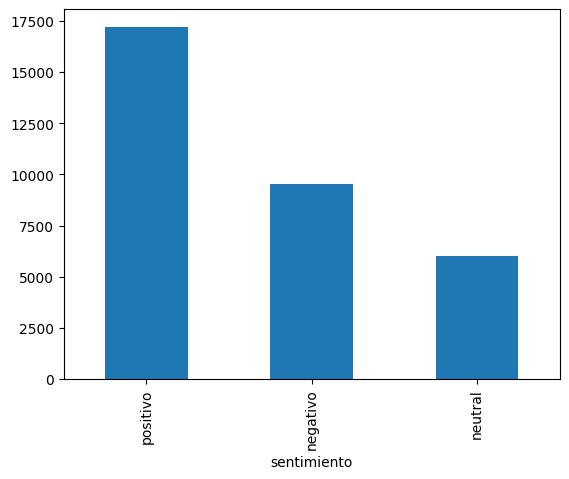

In [ ]:
#Revisamos la distribución de frecnuencias de las reseñas
dataset['sentimiento'].value_counts().plot(kind = 'bar')

Aqui logramos ver que tenemos tres etiquetas posibles. No obstante, la etiqueta que corresponde a 'neutral' tiene un índice de subjetividad igual a 0, y es por eso que se remplazará la etiqueta neutral por negativo.

In [ ]:
#Relizamos el cambio
dataset['sentimiento'].replace(

    to_replace=['neutral'],

    value='negativo',

    inplace=True)

#Revisamos
dataset['sentimiento'].value_counts()

<ipython-input-12-ed5fa705d0f1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['sentimiento'].replace(


,count
sentimiento,
positivo,17217
negativo,15519


##2. Tranformamaos el target (sentimiento) a datos númericos

Para que la red neuronal, sea capaz de procesar las etiquetas, es necesario convertir los valores 'object' en valores numéricos que representen las valoraciones positivas y negativas.

In [ ]:
#Remplazamos 'positivo' por '1'
dataset['sentimiento'].replace(

    to_replace=['positivo'],

    value=1,

    inplace=True)

#Remplazamos 'negativo' por '0'
dataset['sentimiento'].replace(

    to_replace=['negativo'],

    value=0,

    inplace=True)

#Visualizamos
print(dataset['sentimiento'].value_counts())

sentimiento
1    17217
0    15519
Name: count, dtype: int64


<ipython-input-13-21a655ae9548>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['sentimiento'].replace(


##3. Procesamos las Reseñas de los Usuarios

Como las reseñas son cadenas de texto que contienen una serie de características, debemos limpiarlos eliminando los espacios, mayúsculas y puntuaciones. Esto hará posible el adecuado procesamiento de las reseñas de la base de datos para el funcionamiento del modelo.

In [ ]:
#Hacemos una función para realizar la limpieza
stop_words_nltk_en =list(set(stopwords.words('english')))

def reseña_limpia(texto):
  """
  Recibe un texto
  Retorna un texto sin simbolos, espacios, stopwords y en minusculas
  """
  reseña_limpia = str(texto).lower() #Pasamos a minusculas
  reseña_limpia = re.sub(r"[^a-zA-Z]",' ',reseña_limpia) #Eliminamos simbolos
  reseña_limpia = reseña_limpia.split() # Separacion de tokens
  reseña_limpia =[w for w in reseña_limpia if w not in stop_words_nltk_en] # Eliminacción de stop word
  reseña_limpia = ' '.join(reseña_limpia) #Unimos las palabras
  return reseña_limpia

In [ ]:
#Creamos la columna
dataset['reseña_limpia'] = dataset['review'].apply(reseña_limpia)

#Visualizamos
dataset['reseña_limpia']

,reseña_limpia
0,look like someone spit food normal transaction...
1,mcdonalds far food atmosphere go staff make di...
2,made mobile order got speaker checked line mov...
3,mc crispy chicken sandwich customer service qu...
4,repeat order times drive thru still manage mes...
...,...
33391,treated badly
33392,service good
33393,remove hunger enough
33394,good lately become expensive


##4. Extraemos del dataset, las características y etiquetas de clasificación de los datos

In [ ]:
#La columna correspondiente a la entrada de la red neuronal es la columna que acabamos de organizar 'reseña_limpia'
x= dataset['reseña_limpia']

print(x)

0        look like someone spit food normal transaction...
1        mcdonalds far food atmosphere go staff make di...
2        made mobile order got speaker checked line mov...
3        mc crispy chicken sandwich customer service qu...
4        repeat order times drive thru still manage mes...
                               ...                        
33391                                        treated badly
33392                                         service good
33393                                 remove hunger enough
33394                         good lately become expensive
33395                                       took good care
Name: reseña_limpia, Length: 32736, dtype: object


In [ ]:
#Ahora, las etiquetas de clasificación corresponden a la columna que creamos con base al sentimiento de la reseña ('sentimiento')
y=dataset['sentimiento']

print(y)

0        1
1        1
2        0
3        0
4        0
        ..
33391    0
33392    1
33393    0
33394    1
33395    1
Name: sentimiento, Length: 32736, dtype: int64


##5. Preparamos el conjunto de entrenamiento y de prueba

In [ ]:
#Importamos librerias adicionales
from sklearn.model_selection import train_test_split

#Separamos los datos en donde un 80% de los datos serán para el entrenamiento y un 20% para validación (prueba)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

##6. Definimos los Hiperparámetros

Parámetro de Frecuencia. Uno de los parámetros a utilizar, será aquel que me permite tener un vector que contenga el número máximo de las palabras mas frecuentes dentro del texto. Recordar que este tipo de red neuronal, busca patrones de secuencias de palabras en torno a las valoraciones positivas o negativas y en base a esto, realizar la asociación respectiva con la etiqueta de valoración.

In [ ]:
#Importamos librerias adicionales
from tensorflow.keras.preprocessing.text import Tokenizer

#Creamos párametros de frecuencia (Estos nos permiten tener un vector que contenga un número máximo de las palabras dentro del texto)
NUMBER_OF_WORDS = 20000

MAX_LEN = 100

tokenizer = Tokenizer(num_words = NUMBER_OF_WORDS)

tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)

x_test = tokenizer.texts_to_sequences(x_test)

Para las entradas de la red, las secuencias de palabras seben contar con la misma longitud. Lo que haremos es que para que todas las reseñas cuenten con la misma longitud se van a agregar espacios al final de las reseñas cortas (utilizando la función padding de tensorflow) para que el modelo pueda procesarlo de la mejor manera.

In [ ]:
#Importamos librerias adicionales
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Realizamos el proceso explicado anteriormente
x_train = pad_sequences(x_train, padding='post', maxlen=MAX_LEN)

x_test = pad_sequences(x_test, padding='post', maxlen=MAX_LEN)

##7. Diseñamos la arquitectura de la red neuronal (RNN)

In [ ]:
#Definimos una variable model, siendo estala arquitectura de la red con una secuencia de capas de muchas entradas y una salida
model = tf.keras.Sequential()

Para este modelo crearemos tres capas. La primera de ellas, será una capa embebida la cual recibirá todas las secuencias de palabras preparadas en el punto anterior. Luego de eso, tendremos una capa con 128 neuronas y una función de activación tangencial hiperbólica. Finalmente, tendremos una última capa densa con una función de activación sigmoidal.

###**1. Capa Embedida**

In [ ]:
# Parámetros de la capa
vocab_size = 20000  # Número total de palabras en el vocabulario
embed_size = 128  # Dimensión del espacio vectorial de cada palabra

# Creación de la capa
model.add(tf.keras.layers.Embedding(vocab_size,embed_size, input_shape=(x_train.shape[1],)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


###**Segunda Capa**

In [ ]:
#Esta capa, también contiene 128 neuronas y tiene una función de activación tangente hiperbólica
#Esta capa procesará las relaciones o secuencias de palabras asociadas a las valoraciones de los usuarios.
model.add(tf.keras.layers.LSTM(units=128, activation="tanh"))

###**Última Capa**

In [ ]:
#Finalmente tenemos la última capa que contiene tan solo una neurona, esto porque tenemos una salida binaria (valoración positiva o negativa)
#La función sigmoide se aplica ya que lo que queremos es obtener una probabilidad de que una reseña sea positiva o negativa, dependiendo de que tan cerca este de cero o 1

#Cargamos librerias adicionales
from tensorflow.keras.layers import Dense

#Creamos la capa
model.add(Dense(1, activation='sigmoid'))

##7. Compilación del Modelo

Para procesar la arquitectura se implementarán los siguientes parámetros, puesto que los tres elementos trabajan juntos para entrenar el modelo y obtener un buen rendimiento en la tarea de clasificación de sentimientos

* **RMSprop:** ajusta los parámetros de la red para minimizar la función de pérdida.
* **binary_crossentropy:** mide la diferencia entre las predicciones y los valores reales.
* **accuracy:** evalúa el porcentaje de predicciones correctas.



In [ ]:
#Implementamos los parámetros
model.compile(optimizer='rmsprop',

                loss='binary_crossentropy',

                metrics=['accuracy'])

#Mostramos el resumen de la arquitectura de nuestra red neuronal
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,691,845 (10.27 MB)

 Trainable params: 2,691,845 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

## 8.Entrenamos el Modelo

In [ ]:
#Entrenamos con los datos de entrenamiento
model.fit(x_train, y_train, epochs=5, batch_size=128)

Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 92s 449ms/step - accuracy: 0.5281 - loss: 0.6917
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 133s 406ms/step - accuracy: 0.5235 - loss: 0.6922
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 137s 385ms/step - accuracy: 0.5239 - loss: 0.6921
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 76s 372ms/step - accuracy: 0.5256 - loss: 0.6919
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 76s 373ms/step - accuracy: 0.5252 - loss: 0.6920


In [ ]:
#Ahora, lo hacemos con los datos de prueba
test_loss, test_acurracy = model.evaluate(x_test, y_test)

print("Test accuracy: {}".format(test_acurracy))

205/205 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.5227 - loss: 0.6922
Test accuracy: 0.526114821434021


Como resultado final obtenemos un buen 'accuracy' para este tipo de red neuronal del 52.27%